## week10
### REINFORCE in PyTorch
__This notebook is based on [Practical_RL week06](https://github.com/yandexdataschool/Practical_RL/tree/master/week06_policy_based) materials__

Just like we did before for q-learning, this time we'll design a pytorch network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate qlearning, so you'll find it more or less familiar and even simpler.

In [ ]:
!pip install gym==0.22

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


In [ ]:
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


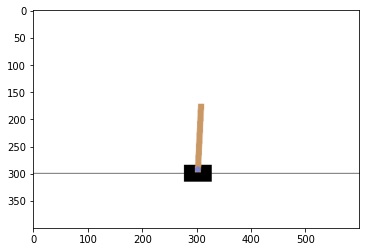

In [ ]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))
env.close()

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states. Let's define such a model below.

In [ ]:
import torch
import torch.nn as nn

In [ ]:
sample = env.reset()

In [ ]:
sample.shape

(4,)

In [ ]:
state_dim = sample.shape[0]

In [ ]:
n_actions = env.action_space.n
n_actions

2

In [ ]:
# Build a simple neural network that predicts policy logits. 
# Keep it simple: CartPole isn't worth deep architectures.
model = nn.Sequential(
  # < YOUR CODE HERE: define a neural network that predicts policy logits >
  nn.Linear(state_dim, 128), nn.ReLU(),
  nn.Linear(128, 64), nn.ReLU(),
  nn.Linear(64, n_actions),
)

#### Predict function

In [ ]:
from torch.nn import functional as F

In [ ]:
def predict_probs(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability
    states = torch.FloatTensor(states)
    logits = model(states).detach()
    probs = F.softmax(logits, dim=-1).numpy()
    return probs

In [ ]:
test_states = np.array([env.reset() for _ in range(5)])
test_probas = predict_probs(test_states)
assert isinstance(
    test_probas, np.ndarray), "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (
    test_states.shape[0], env.action_space.n), "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1),
                   1), "probabilities do not sum to 1"

### Play the game

We can now use our newly built agent to play the game.

In [ ]:
def generate_session(t_max=1000):
    """ 
    play a full session with REINFORCE agent and train at the session end.
    returns sequences of states, actions andrewards
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([s]))[0]

        # Sample action with given probabilities.
        a = np.random.choice(np.arange(n_actions), p=action_probs)
        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [ ]:
# test it
states, actions, rewards = generate_session()

In [ ]:
len(states)

17

### Computing cumulative rewards

In [ ]:
def get_cumulative_rewards(
    rewards,  # rewards at each step
    gamma=0.99,  # discount for reward
):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative returns (a.k.a. G(s,a) in Sutton '16)
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    G = np.zeros_like(rewards, dtype=float)
    G[-1] = rewards[-1]
    for idx in range(-2, -len(rewards) -1, -1):
        G[idx] = rewards[idx] + gamma * G[idx+1]
    return G

In [ ]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9), [
                   1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, -2, 3, -4, 0], gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, 2, 3, 4, 0], gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [ ]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims
    ).scatter_(1, y_tensor, 1)
    return y_one_hot

In [ ]:
# Your code: define optimizers
optimizer = torch.optim.Adam(model.parameters(), 1e-3)


def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-3):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    # predict logits, probas and log-probas using an agent.
    logits = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(
        log_probs * to_one_hot(actions, env.action_space.n), dim=1)
   
    # Compute loss here. Don't forget entropy regularization with `entropy_coef` 
    entropy = -torch.mean(torch.sum(probs * log_probs), dim=-1)
    loss = -torch.mean(log_probs_for_actions * cumulative_returns) - entropy * entropy_coef

    # Gradient descent step
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # technical: return session rewards to print them later
    return np.sum(rewards)

### The actual training

In [ ]:
for i in range(100):
    rewards = [train_on_session(*generate_session())
               for _ in range(100)]  # generate new sessions
    print("mean reward:%.3f" % (np.mean(rewards)))
    if np.mean(rewards) > 500:
        print("You Win!")  # but you can train even further
        break

<ipython-input-20-98733bb04503>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  states = torch.tensor(states, dtype=torch.float32)


mean reward:25.390
mean reward:46.360
mean reward:102.540
mean reward:170.850
mean reward:185.580
mean reward:110.770
mean reward:186.880
mean reward:207.080
mean reward:329.690
mean reward:918.170
You Win!


### Video

In [ ]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-3]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

### Bonus area: solving Acrobot-v1
Try to solve more complex environment using Policy gradient method.
*Hint: you will need add some imporovements to the original REINFORCE (e.g. Advantage Actor Critic or anything else).*

In [ ]:
env = gym.make("Acrobot-v1")
env.reset()

# plt.imshow(env.render("rgb_array"))
state_dim = env.reset().shape[0]
n_actions = env.action_space.n

print(state_dim, n_actions)

6 3


In [ ]:
# Build a simple neural network that predicts policy logits. 
# Keep it simple: CartPole isn't worth deep architectures.
model = nn.Sequential(
  # < YOUR CODE HERE: define a neural network that predicts policy logits >
  nn.Linear(state_dim, 128), nn.ReLU(),
  nn.Linear(128, 64), nn.ReLU(),
  nn.Linear(64, n_actions),
)

In [ ]:
# test it
states, actions, rewards = generate_session()

In [ ]:
len(states)

500

In [ ]:
# Your code: define optimizers
optimizer = torch.optim.Adam(model.parameters(), 1e-3)


def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-3):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    # predict logits, probas and log-probas using an agent.
    logits = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(
        log_probs * to_one_hot(actions, env.action_space.n), dim=1)
   
    # Compute loss here. Don't forget entropy regularization with `entropy_coef` 
    entropy = -torch.mean(torch.sum(probs * log_probs), dim=-1)
    loss = -torch.mean(log_probs_for_actions * (cumulative_returns - torch.mean(cumulative_returns))) - entropy * entropy_coef

    # Gradient descent step
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # technical: return session rewards to print them later
    return np.sum(rewards)

In [ ]:
 for i in range(100):
    rewards = [train_on_session(*generate_session())
               for _ in range(100)]  # generate new sessions
    print("mean reward:%.3f" % (np.mean(rewards)))
    if np.mean(rewards) > -100:
        print("You Win!")  # but you can train even further
        break

mean reward:-500.000
mean reward:-500.000
mean reward:-500.000
mean reward:-499.920
mean reward:-498.250
mean reward:-289.210
mean reward:-240.920
mean reward:-190.640
mean reward:-146.510
mean reward:-174.770
mean reward:-152.430
mean reward:-123.700
mean reward:-142.600
mean reward:-125.180
mean reward:-120.290
mean reward:-131.240
mean reward:-129.010
mean reward:-129.590
mean reward:-128.430
mean reward:-115.270
mean reward:-121.190
mean reward:-121.300
mean reward:-118.700
mean reward:-129.670
mean reward:-122.940
mean reward:-117.470
mean reward:-112.460
mean reward:-114.860
mean reward:-123.780
mean reward:-110.360
mean reward:-108.680
mean reward:-103.900
mean reward:-108.450
mean reward:-102.800
mean reward:-101.280
mean reward:-109.960
mean reward:-116.790
mean reward:-136.230
mean reward:-117.860
mean reward:-139.130
mean reward:-119.550
mean reward:-153.910
mean reward:-147.140
mean reward:-131.750
mean reward:-127.410
mean reward:-102.640
mean reward:-88.020
You Win!


In [ ]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("Acrobot-v1"),
                           directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-3]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))